<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B3%BC_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [23]:
#json불러오기
df = pd.read_json('user_rating_1000.json')


In [24]:
# 평점이 0인 데이터 훈련데이터에서 제거
non_zero_df = df[df['rating'] != 0]

# 피봇테이블 만들기
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)

# 훈련,테스트 데이터셋 분리
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

# Flatten the matrix and create user-item pairs
train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# Model inputs
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# Embeddings
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# Flatten the embeddings
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# Dot product of user and item embeddings
y_hat = Dot(axes=1)([user_vector, item_vector])

# Create and compile model
model = Model(inputs=[user_input, item_input], outputs=y_hat)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Model summary
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',  # 모니터할 지표
    patience=5,  # 지정된 에포크 동안 개선되지 않으면 중단
    verbose=1,
    mode='min',  # 'min' 모니터링 지표가 감소하는 것을 개선으로 봄
    restore_best_weights=True  # 가장 좋은 모델의 가중치로 복원
)

# 모델 학습 (얼리스타핑 적용)
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]  # 콜백 리스트에 얼리스타핑 추가
)




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 15)                15000     ['input_5[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 15)                24945     ['input_6[0][0]']             
                                                                                            

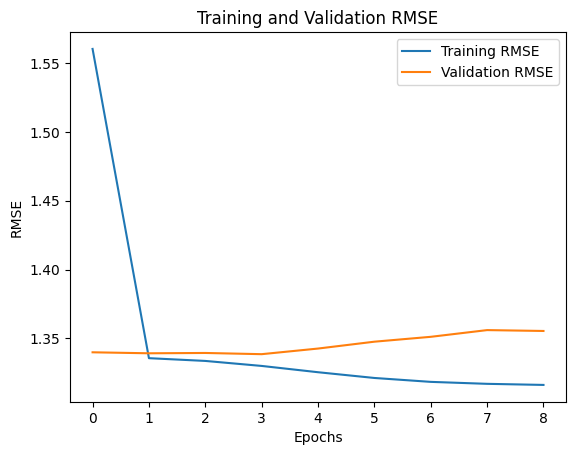

In [25]:
# 시각화
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [26]:
# 모델 저장
model.save('model0425_2200.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# user_id==11의 평점이 0인데이터, 그린까 아직 평점을 매기지 않은 장소 구하기
unrated_places = pivot_table.loc[11].loc[pivot_table.loc[11] == 0].index
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model('model0425_2200.h5')

df2 = df.copy()

# 모델 예측
predictions = model.predict([df2['user_id'], df2['place_id']])

# 예측 평점 출력
print(predictions)

# df2에 'predict_rating' 컬럼추가하기
df2['predict_rating'] = predictions

[[2.6838338 ]
 [3.4067268 ]
 [3.4559479 ]
 ...
 [0.05672209]
 [0.07400932]
 [0.04435556]]
51969/51969 [==============================] - 88s 2ms/step
[[ 3.120891  ]
 [ 3.0278368 ]
 [ 3.2416458 ]
 ...
 [-0.03424933]
 [-0.0572155 ]
 [-0.02479221]]


In [30]:
# user아이디가 11인 사람의 실제 평점과 예측평점
df2[df2['user_id'] == 11].sort_values(by='rating', ascending=False)

,user_id,rating,place_id,predict_rating
18293,11,5.0,0,3.442019
19031,11,5.0,738,3.266089
19039,11,5.0,746,3.510173
19041,11,5.0,748,3.575746
19043,11,5.0,750,3.493366
...,...,...,...,...
18520,11,0.0,227,3.274375
18392,11,0.0,99,3.514619
19329,11,0.0,1036,3.379217
19332,11,0.0,1039,3.597063


In [31]:
# user아이디가 11인 사람의 예측평점구하기
df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)

<ipython-input-31-308c353ac7d3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)


,user_id,rating,place_id,predict_rating
18986,11,0.0,693,3.849994
18930,11,0.0,637,3.801799
19620,11,0.0,1327,3.704074
19537,11,0.0,1244,3.676299
19944,11,0.0,1651,3.667474
19372,11,0.0,1079,3.665999
19108,11,0.0,815,3.651251
19551,11,0.0,1258,3.635589
19423,11,0.0,1130,3.626331
19332,11,0.0,1039,3.597063


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663000 entries, 0 to 1662999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   user_id   1663000 non-null  int64  
 1   rating    1663000 non-null  float64
 2   place_id  1663000 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 38.1 MB
